# 05.Transfer Learning with TesnsorFlow Part 2: Fine-tuning

오늘 배운 핵심 개념:
- fine-tuning transter leanring : 이미 훈련된 모델의 가중치를 다른 모델에 적용한 후 세부 사항을 조정 하여 다른 모델의 학습 데이터에 맞게 함.

- Feautre extractoin transer learning과 fine-tuning transfer learning의 가장 주요한 차이점은 (Feature extraction transfer learning vs. fine-tuning transfer learning. The main difference between the two is that in fine-tuning, more layers of the pre-trained model get unfrozen and tuned on custom data. This fine-tuning usually takes more data than feature extraction to be effective.)

##  What we're going to cover

- Introduce fine-tuning, a type of transfer learning to modify a pre-trained model to be more suited to your data
- Using the Kears Fuctional API (a differnt way to build models in Keras)
- Using a samller dataset to experiment faster (e.g. 1-10% of trainging samples of 10 classes of food)
- Data augmentation (how to maek your trainging dataset more diverse without adding more data)
- Running a series of modelling experiments on our Food Vision data
    - Model 0 : a transer leaning model using the Keras Functional API
    - Model 1 : a feature extraction transfer learning model on 1% of the data with data augmentation
    - Model 2 : a feature extraction transfer learning model on 10% of the data with data qugmentation
    - Model 3: a fine-tuned transfer learningmodel on 10% of the data
    - Model 4: a fine-tuned transfer leanring model on 1000% of the data
- Introduce the ModelCheckpoint callback to save intermediate trainging results
- Compare model experiments results using TensorBoard

In [1]:
import datetime
print(f"Notebook last run (end-to-end) : {datetime.datetime.now()}")

Notebook last run (end-to-end) : 2025-05-31 13:36:30.301725


In [4]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


In [5]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [1]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2025-05-31 13:43:36--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-05-31 13:43:36 (88.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## 10 Food classes: Working with less data

tf.keras.applications : <br>
image_dataset_from_directory() :  <br>
tf.keras.utils <br>

In [2]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2025-05-31 13:43:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.207, 108.177.98.207, 142.250.99.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   253MB/s    in 0.6s    

2025-05-31 13:43:47 (253 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
#  Walk through 10 percent data dire tory and list number of files
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [9]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [10]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical", # what type are the labels?
                                                                            batch_size = 32) # batch_size is 32 by default, ths is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                        image_size=IMG_SIZE,
                                                                        label_mode = "categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


`image_dataset_from_directry()`
- `diretory` : the filepath of the target directory we're loading images in from.
- `image_size` : the target size ot rhe images we're going to load in (height, width)
- `batch_size` : the batch size og the images we're goingto load in. For example if the `batch_size` is 32 (the default), batches of 32 images and labels at a time will be passed to the model.


In [11]:
# Check the training data datatype
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [13]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [14]:
# See an example batch of data
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [9.28571701e-01 9.28571701e-01 0.00000000e+00]
   [0.00000000e+00 2.00000000e+00 0.00000000e+00]
   ...
   [2.33164978e+00 6.61736393e+00 5.56102216e-01]
   [6.86227226e+00 1.21479864e+01 2.60205960e+00]
   [1.15000353e+01 1.70153637e+01 4.77042055e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [9.28571701e-01 9.28571701e-01 0.00000000e+00]
   [0.00000000e+00 2.00000000e+00 0.00000000e+00]
   ...
   [2.83317585e+01 3.12603302e+01 1.37603302e+01]
   [4.12653542e+01 4.41939240e+01 2.68418865e+01]
   [4.54744873e+01 4.83775444e+01 3.11683693e+01]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [9.28571701e-01 9.28571701e-01 0.00000000e+00]
   [0.00000000e+00 2.00000000e+00 0.00000000e+00]
   ...
   [5.45765457e+01 5.73622589e+01 3.06684151e+01]
   [5.38877335e+01 5.58877335e+01 3.24438820e+01]
   [5.05764694e+01 5.24999313e+01 3.17295456e+01]]

  ...

  [[1.93520546e+01 8.70917225e+00 0.00000000e+00]
   [1

## Model 0: Building a transfer learning


In [18]:
# 1. create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model( so the pre-learned patterns remain)
base_model.trainable = False

# 3.Create input into the mase model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name = "input_layer")

# 4. If using ResNet50V2, add this to speed up convergnece, remove for effiecientNetV2
# X = tf.keras.layers.experimental.preprocessing.Resczaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note : usnit tf.keras.applications, EfficientNetV2 inputs don't have tobe normalized)
x = base_model(inputs)
# check data shape after passing it to base_model

# 6. Average pool the outputs of the base model (aggregate all the most important information, redue number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name = "output_layer")(x)

# 8. Combine the inputs with the output into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Complie the model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the mode ( we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data_10_percent,
                                 # Go through lee of the validation data so epoch are faster (we want faster experiments)
                                 validation_steps = int(0.25 * len(test_data_10_percent)),
                                 #  Track out model's training logs for viusalization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20250531-141407
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 880ms/step - accuracy: 0.2525 - loss: 2.0915 - val_accuracy: 0.7451 - val_loss: 1.2664
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.7328 - loss: 1.2415 - val_accuracy: 0.8125 - val_loss: 0.8595
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.7974 - loss: 0.8773 - val_accuracy: 0.8421 - val_loss: 0.6661
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.8268 - loss: 0.7131 - val_accuracy: 0.8618 - val_loss: 0.5852
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.8493 - loss: 0.6340 - val_accuracy: 0.8635 - val_loss: 0.5516


In [20]:
# check layes in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_layer_3
1 rescaling_3
2 normalization_3
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_con

In [21]:
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, None,      │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, None,      │          0 │ rescaling_3[0][0] │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ normalization_3[… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1a_project_… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, None,      │     36,864 │ block2a_project_… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, None,      │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, None,      │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

In [22]:
# Check sumamro of model constructed with Functional API
model_0.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

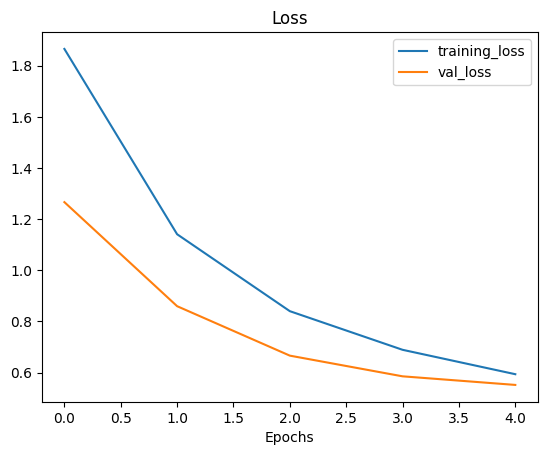

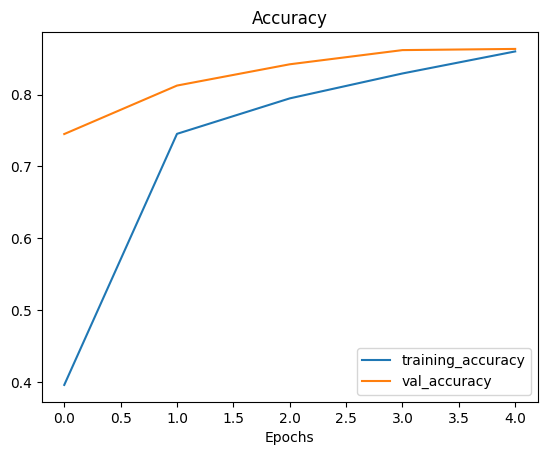

In [24]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vetor form a trained model

- `tf.keras.layers.GlobalAveragePooling2D()` : layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes

In [26]:
# Define input tnesor shpe (same number of dimensions as th output of efficientnetv2-b0)
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor :\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the diffenrent tensors
print(f"shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor : {global_average_pooled_tensor.shape}")

Random input tensor :
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor : (1, 3)


In [28]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis = [1,2]) # aveage across the middel axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [29]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2025-05-31 14:30:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.207, 74.125.199.207, 142.251.188.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   237MB/s    in 0.5s    

2025-05-31 14:30:18 (237 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [30]:
# create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = '10_food_classes_1_percent/test/'

In [31]:
# Walk through 1 percent data directory and list number of files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There a

In [55]:
import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size = 32, # default
                                                                           image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model


In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.Layers.experimenta import preprocessing

# NEW : Newer version of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data aumentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
    # Preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficeintNetV2B0

], name = "data_augmentation")

img.shape : (384, 512, 3)


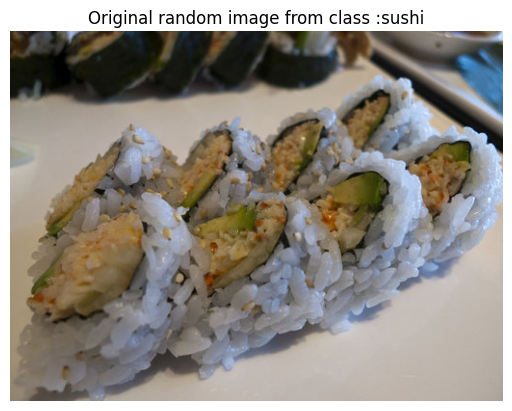

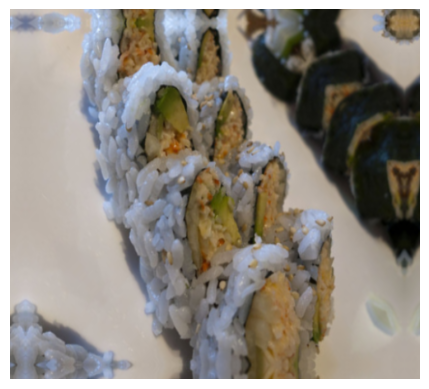

In [53]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names) # choos a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random iamge path
img = mpimg.imread(random_image_path) # read in the chosen target image
print(f"img.shape : {img.shape}")
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class :{target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis = 0)) # data augmentation model required shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # required normaliztion after augmentation
plt.axis(False);


## Model 1 : Feature extraction transfer learning on 1% of the data with data augmentation

In [52]:
# Setup input shpae and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequentail model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmetation) and don't train it
x = base_model(x, training = False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

# Put a dnes layer on as the output
outputs = layers.Dense(10, activation="softmax", name = "output_layers")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accruacy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs = 5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25 * len(test_data)), # validate for less steps
                                # Track model training logs
                                callback = [create_tensorboard_callback("transfer_learning","1_percent_data_aug")])

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "functional_2" is incompatible with the layer: expected shape=(None, 512, 512, 3), found shape=(None, 224, 224, 3)[0m

Arguments received by Sequential.call():
  • args=('<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=input_layer>',)
  • kwargs={'mask': 'None'}

In [27]:
# Check out model summary
model_1.summary()

NameError: name 'model_1' is not defined